### Hail Tutorial

In this tutorial, we will analyze data from the final phase of the [1000 Genomes Project](http://www.internationalgenome.org/about), as described in [A global reference for human genetic variation (Nature 2015)](http://www.nature.com/nature/journal/v526/n7571/full/nature15393.html). We have downsampled the dataset to approximately 10,000 variants consisting of both rare and common variants. We obtained sample information (population, super-population, sex) from the [1000 Genomes website](http://www.internationalgenome.org/data-portal/sample).

If you haven't already installed Hail, go to [Getting Started](https://hail.is/hail/getting_started.html) for instructions.

## Download tutorial data files

Download the zip file *Hail_Tutorial_Data-v2.tgz* using [wget](https://www.google.com/search?q=install+wget) or [curl](https://www.google.com/search?q=install+curl):

<pre class="code noexec">
wget https://storage.googleapis.com/hail-tutorial/Hail_Tutorial_Data-v2.tgz
</pre>

Unzip the file:

<pre class="code noexec">
tar -xvzf Hail_Tutorial_Data-v2.tgz --strip 1
</pre>

The contents are as follows:
  
  - 1000 Genomes compressed VCF (downsampled to 10K variants, 248 samples):
    - *1000Genomes_248samples_coreExome10K.vcf.bgz*
  - Sample annotations:
    - *1000Genomes.sample_annotations*
  - LD-pruned SNP list: 
    - *purcell5k.interval_list*

## Start an IPython interactive shell

Start an IPython shell by running the command `ipython` from the directory containing the tutorial files. You should see a window similar to the one shown below. Otherwise, Anaconda is not installed properly.

<pre class="code noexec">
hail@tutorial-vm:~$ ipython
Python 2.7.12 |Anaconda 4.2.0 (64-bit)| (default, Jul  2 2016, 17:42:40)
Type "copyright", "credits" or "license" for more information.

IPython 5.1.0 -- An enhanced Interactive Python.
?         -> Introduction and overview of IPython's features.
%quickref -> Quick reference.
help      -> Python's own help system.
object?   -> Details about 'object', use 'object??' for extra details.

In [1]:
</pre>

In this window, enter two commands:

In [1]:
from hail import *      
hc = HailContext()

If there is no error, you're ready to start using Hail! Otherwise, make sure that the `export` variables are correctly set and appropriate versions of all dependencies are installed.

Before using Hail, let's import the following Python libraries for use throughout the tutorial. Installing and importing [seaborn](http://seaborn.pydata.org/installing.html) is optional; it just makes the plots prettier.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn
from math import log, isnan

%matplotlib inline

## Import data

We must first import variant data into Hail's internal format of Variant Dataset (VDS). We use the [`import_vcf`](https://hail.is/hail/hail.HailContext.html#hail.HailContext.import_vcf) method on [`HailContext`](https://hail.is/hail/hail.HailContext.html) to load the downsampled 1000 Genomes VCF into Hail. The VCF file is block-compressed (`.vcf.bgz`) which enables Hail to read the file in parallel. Reading files that have not been block-compressed (`.vcf`, `.vcf.gz`) is _significantly_ slower and should be avoided (though often `.vcf.gz` files are in fact block-compressed, in which case renaming to `.vcf.bgz` solves the problem).

In [3]:
vds = hc.import_vcf('1000Genomes_248samples_coreExome10K.vcf.bgz')

We next use the [`split_multi`](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.split_multi) method on `dataset` to split multi-allelic variants into biallelic variants. For example, the variant `1:1000:A:T,C` would become two variants: `1:1000:A:T` and `1:1000:A:C`.

In [4]:
vds = vds.split_multi()

We next use the [`import_table`](https://hail.is/hail/hail.HailContext.html#hail.HailContext.import_table) method to load phenotypic information into a Hail [`KeyTable`](https://hail.is/hail/hail.KeyTable.html#hail.KeyTable) object. We can use this to annotate samples.

In [7]:
table = hc.import_table('1000Genomes.sample_annotations', impute=True).key_by('Sample')

Here `1000Genomes.sample_annotations` refers to the sample annotation data file. `%%sh` is a handy IPython magic command that allows you to peek at this file without leaving the IPython interpreter.

In [8]:
%%sh
head 1000Genomes.sample_annotations | column -t

Sample   Population  SuperPopulation  isFemale  PurpleHair  CaffeineConsumption
HG00096  GBR         EUR              False     False       77.0
HG00097  GBR         EUR              True      True        67.0
HG00098  GBR         EUR              False     False       83.0
HG00099  GBR         EUR              True      False       64.0
HG00100  GBR         EUR              True      False       59.0
HG00101  GBR         EUR              False     True        77.0
HG00102  GBR         EUR              True      True        67.0
HG00103  GBR         EUR              False     True        74.0
HG00104  GBR         EUR              True      False       66.0


We can use Spark Dataframes to preview the table, which is certainly the better way to do it!

In [9]:
table.to_dataframe().show()

+-------+----------+---------------+--------+----------+-------------------+
| Sample|Population|SuperPopulation|isFemale|PurpleHair|CaffeineConsumption|
+-------+----------+---------------+--------+----------+-------------------+
|HG00096|       GBR|            EUR|   false|     false|               77.0|
|HG00097|       GBR|            EUR|    true|      true|               67.0|
|HG00098|       GBR|            EUR|   false|     false|               83.0|
|HG00099|       GBR|            EUR|    true|     false|               64.0|
|HG00100|       GBR|            EUR|    true|     false|               59.0|
|HG00101|       GBR|            EUR|   false|      true|               77.0|
|HG00102|       GBR|            EUR|    true|      true|               67.0|
|HG00103|       GBR|            EUR|   false|      true|               74.0|
|HG00104|       GBR|            EUR|    true|     false|               66.0|
|HG00105|       GBR|            EUR|   false|     false|               77.0|

Now, let's annotate the dataset with this table. We do this with the [`annotate_samples_table`](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.annotate_samples_table) method.

In this method, the `root` argument specifies where in sample annotations to put this data. For sample annotations, the root must start with `sa` followed by a `.` and the rest is up to you, so let's use `sa.pheno`.

In [10]:
vds = vds.annotate_samples_table(table, root='sa.pheno')

Finally, we'll [`write`](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.write) the dataset to disk so that all future computations begin by reading in the fast VDS rather than the slow VCF.

In [11]:
out_path = '1kg.vds'
vds.write(out_path, overwrite=True)

## Start exploring

Now we're ready to start exploring! Let's practice [`reading`](https://hail.is/hail/hail.HailContext.html#hail.HailContext.read) the dataset back in:

In [12]:
vds = hc.read(out_path)

First, we'll print some statistics about the size of the dataset using [`summarize`](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.summarize):

In [13]:
vds.summarize().report()


         Samples: 284
        Variants: 10961
       Call Rate: 0.986588
         Contigs: ['X', '12', '8', '19', '4', '15', '11', '9', '22', '13', '16', '5', '10', '21', '6', '1', '17', '14', '20', '2', '18', '7', '3']
   Multiallelics: 0
            SNPs: 10961
            MNPs: 0
      Insertions: 0
       Deletions: 0
 Complex Alleles: 0
    Star Alleles: 0
     Max Alleles: 2


So the call rate before any QC filtering is about 98.7%.

Let's print the types of all annotations.

In [14]:
print('variant annotations:')
print(vds.variant_schema)
print('\nsample annotations:')
print(vds.sample_schema)
print('\nglobal annotations:')
print(vds.global_schema)

variant annotations:
Struct {
    rsid: String,
    qual: Double,
    filters: Set[String],
    info: Struct {
        AC: Array[Int],
        AF: Array[Double],
        AN: Int,
        BaseQRankSum: Double,
        ClippingRankSum: Double,
        DP: Int,
        DS: Boolean,
        FS: Double,
        HaplotypeScore: Double,
        InbreedingCoeff: Double,
        MLEAC: Array[Int],
        MLEAF: Array[Double],
        MQ: Double,
        MQ0: Int,
        MQRankSum: Double,
        QD: Double,
        ReadPosRankSum: Double,
        set: String
    }
}

sample annotations:
Struct {
    pheno: Struct {
        Population: String,
        SuperPopulation: String,
        isFemale: Boolean,
        PurpleHair: Boolean,
        CaffeineConsumption: Double
    }
}

global annotations:
Empty


Note the annotations imported from the original VCF, as well as the sample annotations added above. Notice how those six sample annotations loaded above are nested inside `sa.pheno` as defined by the `root` option in [`annotate_samples_table`](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.annotate_samples_table).

Next we'll add some global annotations including the list of populations that are present in our dataset and the number of samples in each population, using the Hail expression language and the [`query_samples`](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.query_samples) method. The 1000 Genomes Super-Population codings are:

  - SAS = South Asian
  - AMR = Americas
  - EUR = European
  - AFR = African
  - EAS = East Asian

We'll first build up a list of query expressions, then evaluate them all at once to save time.

In [15]:
expressions = [ 
  'samples.map(s => sa.pheno.Population).collect().toSet()',
  'samples.map(s => sa.pheno.SuperPopulation).collect().toSet()',
  'samples.filter(s => sa.pheno.PurpleHair).count()',
  'samples.filter(s => !sa.pheno.PurpleHair).count()' ]
[populations, super_populations, case_count, control_count] = vds.query_samples(expressions)

print('populations = %s' % populations)
print('super populations = %s' % super_populations)
print('case count = %s' % case_count)
print('control count = %s' % control_count)
print('total samples = %s' % vds.num_samples)

populations = set([u'GWD', u'TSI', u'BEB', u'PEL', u'LWK', u'MSL', u'GBR', u'IBS', u'ASW', u'FIN', u'KHV', u'CEU', u'CLM', u'CHB', u'YRI', u'STU', u'CHS', u'ESN', u'ACB', u'GIH', u'PJL', u'MXL', u'ITU', u'CDX', u'JPT', u'PUR'])
super populations = set([u'SAS', u'EAS', u'AMR', u'AFR', u'EUR'])
case count = 140
control count = 144
total samples = 284


Now it's easy to count samples by population using the [`counter()`](https://hail.is/hail/types.html#aggregable-t) aggregator:

In [16]:
[counter] = vds.query_samples(['samples.map(s => sa.pheno.SuperPopulation).counter()'])
for k, v in counter.iteritems():
    print('population %s found %s times' % (k, v))

population SAS found 55 times
population EAS found 72 times
population AMR found 34 times
population AFR found 76 times
population EUR found 47 times


## Quality control (QC)

Before running genotype-phenotype association tests, we better clean up the raw data! We'll filter out:

- genotypes that don't have strong evidence supporting the genotype call
- samples that are outliers on key summary statistics across the dataset
- variants with low mean genotype quality or out of [Hardy-Weinberg equilibrium](https://en.wikipedia.org/wiki/Hardy–Weinberg_principle).

The QC procedures below are a sampler covering various features of Hail, not an optimal pipeline for your research.

For filtering, we make extensive use of the [Hail expression language](https://hail.is/hail/exprlang.html). Here `g` is genotype, `v` is variant, `s` is sample, and annotations are accessible via `va`, `sa`, and `global`. 

### Filter genotypes

Let's filter genotypes based on allelic balance using the [`filter_genotypes`](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.filter_genotypes) method.

In [17]:
filter_condition_ab = '''let ab = g.ad[1] / g.ad.sum() in
                         ((g.isHomRef() && ab <= 0.1) || 
                          (g.isHet() && ab >= 0.25 && ab <= 0.75) || 
                          (g.isHomVar() && ab >= 0.9))'''
vds_gAB = vds.filter_genotypes(filter_condition_ab)

In this code, we first construct an expression  `filter_condition_ab` that evaluates to a Boolean. We use `let ... in` syntax to define a temporary variable `ab` for the allelic balance which is calculated from the allelic depth `g.ad`, a zero-indexed array (so `g.ad[0]` and `g.ad[1]` are read counts for reference allele and unique alternate allele, respectively; this dataset is bi-allelic, but Hail supports multi-allelic variants as well). We require for homozygous calls that the allelic balance be within `.1` of the expected mode, and that for heterozygote calls (`g.isHet()`) the allelic balance be between 0.25 and 0.75. Additional methods on genotype are documented [here](https://hail.is/hail/types.html#genotype).

In [18]:
vds_gAB.summarize().call_rate

0.9506367646624203

Now the call rate is about 95%, so nearly 4% of genotypes failed the filter. Filtering out a genotype is equivalent to setting the genotype call to missing.

### Filter samples

Having removed suspect genotypes, let's next remove variants with low call rate using [`filter_variants_expr`](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.filter_variants_expr) and then calculate summary statistics per sample with the [`sample_qc`](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.sample_qc) method.

In [19]:
vds_gAB_vCR = (vds_gAB
    .filter_variants_expr('gs.fraction(g => g.isCalled()) > 0.95')
    .sample_qc())

The call rate for each variant is calculated using the `fraction` [aggregable](https://hail.is/hail/types.html#aggregable-genotype) on the genotypes `gs`. `sample_qc` adds a number of statistics to sample annotations:

In [20]:
print(vds_gAB_vCR.sample_schema)

Struct {
    pheno: Struct {
        Population: String,
        SuperPopulation: String,
        isFemale: Boolean,
        PurpleHair: Boolean,
        CaffeineConsumption: Double
    },
    qc: Struct {
        callRate: Double,
        nCalled: Int,
        nNotCalled: Int,
        nHomRef: Int,
        nHet: Int,
        nHomVar: Int,
        nSNP: Int,
        nInsertion: Int,
        nDeletion: Int,
        nSingleton: Int,
        nTransition: Int,
        nTransversion: Int,
        dpMean: Double,
        dpStDev: Double,
        gqMean: Double,
        gqStDev: Double,
        nNonRef: Int,
        rTiTv: Double,
        rHetHomVar: Double,
        rInsertionDeletion: Double
    }
}


Let's export these sample annotations to a text file and take a look at them:

In [21]:
vds_gAB_vCR.export_samples('sampleqc.txt', 'Sample = s, sa.qc.*')

In [22]:
%%sh
head sampleqc.txt | cut -f 1-10

Sample	callRate	nCalled	nNotCalled	nHomRef	nHet	nHomVar	nSNP	nInsertion	nDeletion
HG00096	9.63127e-01	6086	233	4289	923	874	2671	0	0
HG00099	9.75629e-01	6165	154	4249	1046	870	2786	0	0
HG00105	9.75154e-01	6162	157	4326	1025	811	2647	0	0
HG00118	9.86707e-01	6235	84	4270	1157	808	2773	0	0
HG00129	9.76420e-01	6170	149	4226	1114	830	2774	0	0
HG00148	9.81010e-01	6199	120	4241	1095	863	2821	0	0
HG00177	9.35908e-01	5914	405	4179	740	995	2730	0	0
HG00182	9.11695e-01	5761	558	4028	751	982	2715	0	0
HG00242	9.51100e-01	6010	309	4237	830	943	2716	0	0


We can further analyze these results locally using Python's [matplotlib](http://matplotlib.org/) library. Below is an example plot of two variables (call rate and meanGQ), along with the code that generate the plot.

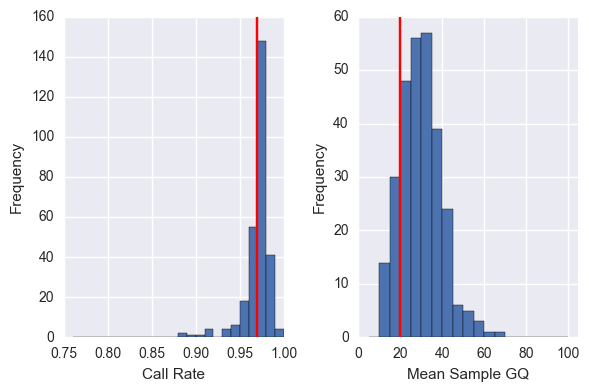

In [23]:
sampleqc_table = vds_gAB_vCR.samples_keytable().to_pandas()

plt.subplot(1, 2, 1) 
plt.hist(sampleqc_table["sa.qc.callRate"], bins=np.arange(.75, 1.01, .01))
plt.xlabel("Call Rate")
plt.ylabel("Frequency")
plt.xlim(.75, 1)
plt.axvline(.97, color='r')

plt.subplot(1, 2, 2)
plt.hist(sampleqc_table["sa.qc.gqMean"], bins=np.arange(0, 105, 5))
plt.xlabel("Mean Sample GQ")
plt.ylabel("Frequency")
plt.xlim(0, 105)
plt.axvline(20, color = 'r')

plt.tight_layout()
plt.show()

Let's remove the samples that are outliers in the plots above, where cutoffs are given by the red lines. We'll remove these samples from `vds_gAB` (after filtering genotypes but before filtering variants) because it's possible that poor-quality samples decreased the call rate on variants we'd actually like to keep. Here is one of the many ways we could do this step:

In [25]:
vds_gAB_sCR_sGQ = (vds_gAB
    .annotate_samples_table(vds_gAB_vCR.samples_keytable(), expr='sa.qc = table.qc')
    .filter_samples_expr('sa.qc.callRate >= 0.97 && sa.qc.gqMean >= 20'))

As before, let's use the [`query_samples`](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.query_samples) method to count the number of samples by phenotype that remain in the dataset after filtering.

In [26]:
post_qc_exprs = [
    'samples.filter(s => sa.pheno.PurpleHair).count()',
    'samples.filter(s => !sa.pheno.PurpleHair).count()' ]
[num_cases, num_controls] = vds_gAB_sCR_sGQ.query_samples(post_qc_exprs)
print('case count is %s, control count is %s' % (num_cases, num_controls))

case count is 93, control count is 99


### Filter variants

We now have `vds_gAB_sCR_sGQ`, a VDS where low-quality genotypes and samples have been removed.

Let's use the [`variant_qc`](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.variant_qc) method to start exploring variant metrics:

In [27]:
vds_gAB_sCR_sGQ = vds_gAB_sCR_sGQ.variant_qc()

print(vds_gAB_sCR_sGQ.variant_schema)

Struct {
    rsid: String,
    qual: Double,
    filters: Set[String],
    info: Struct {
        AC: Array[Int],
        AF: Array[Double],
        AN: Int,
        BaseQRankSum: Double,
        ClippingRankSum: Double,
        DP: Int,
        DS: Boolean,
        FS: Double,
        HaplotypeScore: Double,
        InbreedingCoeff: Double,
        MLEAC: Array[Int],
        MLEAF: Array[Double],
        MQ: Double,
        MQ0: Int,
        MQRankSum: Double,
        QD: Double,
        ReadPosRankSum: Double,
        set: String
    },
    qc: Struct {
        callRate: Double,
        AC: Int,
        AF: Double,
        nCalled: Int,
        nNotCalled: Int,
        nHomRef: Int,
        nHet: Int,
        nHomVar: Int,
        dpMean: Double,
        dpStDev: Double,
        gqMean: Double,
        gqStDev: Double,
        nNonRef: Int,
        rHeterozygosity: Double,
        rHetHomVar: Double,
        rExpectedHetFrequency: Double,
        pHWE: Double
    }
}


We've once again used matplotlib to make histograms of four summary statistics (call rate, allele frequency, mean GQ, and Hardy Weinberg Equilibrium p-value. Notice how the histogram for HWE is massively inflated for small p-values. This is because we calculated HWE p-values with all five populations lumped together.

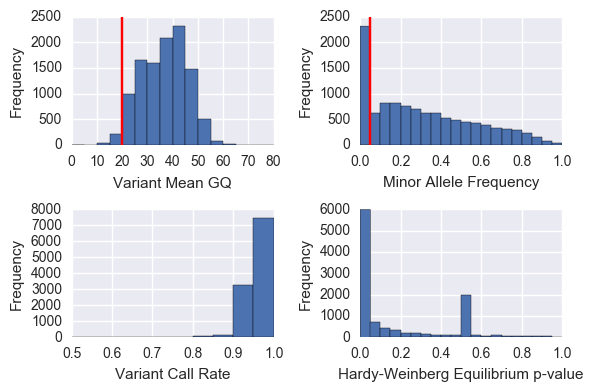

In [28]:
variantqc_table = vds_gAB_sCR_sGQ.variants_keytable().to_pandas()

plt.subplot(2, 2, 1)
variantgq_means = variantqc_table["va.qc.gqMean"]
plt.hist(variantgq_means, bins=np.arange(0, 85, 5))
plt.xlabel("Variant Mean GQ")
plt.ylabel("Frequency")
plt.xlim(0, 80)
plt.axvline(20, color = 'r')

plt.subplot(2, 2, 2)
variant_mleaf = variantqc_table["va.qc.AF"]
plt.hist(variant_mleaf, bins=np.arange(0, 1.05, .05))
plt.xlabel("Minor Allele Frequency")
plt.ylabel("Frequency")
plt.xlim(0, 1)
plt.axvline(0.05, color = 'r')

plt.subplot(2, 2, 3)
plt.hist(variantqc_table['va.qc.callRate'], bins=np.arange(0, 1.05, .05))
plt.xlabel("Variant Call Rate")
plt.ylabel("Frequency")
plt.xlim(.5, 1)

plt.subplot(2, 2, 4)
plt.hist(variantqc_table['va.qc.pHWE'], bins = np.arange(0, 1.05, .05))
plt.xlabel("Hardy-Weinberg Equilibrium p-value")
plt.ylabel("Frequency")
plt.xlim(0, 1)

plt.tight_layout()
plt.show()

Let's use the [`annotate_variants_expr`](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.annotate_variants_expr) method to programmatically compute Hardy Weinberg Equilibrium for each population. First, we construct `hwe-expressions`.

In [29]:
hwe_expressions = [
    'va.hweByPop.hweEUR = gs.filter(g => sa.pheno.SuperPopulation == "EUR").hardyWeinberg()',
    'va.hweByPop.hweSAS = gs.filter(g => sa.pheno.SuperPopulation == "SAS").hardyWeinberg()',
    'va.hweByPop.hweAMR = gs.filter(g => sa.pheno.SuperPopulation == "AMR").hardyWeinberg()',
    'va.hweByPop.hweAFR = gs.filter(g => sa.pheno.SuperPopulation == "AFR").hardyWeinberg()',
    'va.hweByPop.hweEAS = gs.filter(g => sa.pheno.SuperPopulation == "EAS").hardyWeinberg()' ]

We can do this more tersely using list comprehensions in Python; we'll use this approach in the remainder of the tutorial.

In [30]:
populations = ['EUR', 'SAS', 'AMR', 'AFR', 'EAS']
hwe_expressions = ['va.hweByPop.hwe%s = gs.filter(g => sa.pheno.SuperPopulation == "%s").hardyWeinberg()' % (pop, pop) for pop in populations]

Now we can go ahead and use [`annotate_variants_expr`](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.annotate_variants_expr).

In [31]:
vds_gAB_sCR_sGQ = vds_gAB_sCR_sGQ.annotate_variants_expr(hwe_expressions).persist()

print(vds_gAB_sCR_sGQ.variant_schema)

Struct {
    rsid: String,
    qual: Double,
    filters: Set[String],
    info: Struct {
        AC: Array[Int],
        AF: Array[Double],
        AN: Int,
        BaseQRankSum: Double,
        ClippingRankSum: Double,
        DP: Int,
        DS: Boolean,
        FS: Double,
        HaplotypeScore: Double,
        InbreedingCoeff: Double,
        MLEAC: Array[Int],
        MLEAF: Array[Double],
        MQ: Double,
        MQ0: Int,
        MQRankSum: Double,
        QD: Double,
        ReadPosRankSum: Double,
        set: String
    },
    qc: Struct {
        callRate: Double,
        AC: Int,
        AF: Double,
        nCalled: Int,
        nNotCalled: Int,
        nHomRef: Int,
        nHet: Int,
        nHomVar: Int,
        dpMean: Double,
        dpStDev: Double,
        gqMean: Double,
        gqStDev: Double,
        nNonRef: Int,
        rHeterozygosity: Double,
        rHetHomVar: Double,
        rExpectedHetFrequency: Double,
        pHWE: Double
    },
    hweByPop: Str

Above, for each variant, we filter the genotypes to only those genotypes from the population of interest using a filter function on the [genotype aggregable](https://hail.is/hail/types.html#aggregable-genotype) and then calculate the Hardy-Weinberg Equilibrium p-value using the `hardyWeinberg()` function on the filtered genotype aggregable.

The [`persist`](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.persist) method caches the dataset in its current state on memory/disk, so that downstream processing will be faster. 

Printing the schema reveals that we've added new fields to the variant annotations for HWE p-values for each population. We've got quite a few variant annotations now! Notice that the results of these annotation statements are structs containing two elements:

<pre class="code noexec">
...
        hweEUR: Struct {
            rExpectedHetFrequency: Double,
            pHWE: Double
        },
        hweSAS: Struct {
            rExpectedHetFrequency: Double,
            pHWE: Double
        },
        hweAMR: Struct {
            rExpectedHetFrequency: Double,
            pHWE: Double
        },
        hweAFR: Struct {
            rExpectedHetFrequency: Double,
            pHWE: Double
        },
        hweEAS: Struct {
            rExpectedHetFrequency: Double,
            pHWE: Double
        }
    }
}
</pre>

We can now filter variants based on HWE p-values with respect to each population.

In [32]:
hwe_filter_expression = " && ".join(['va.hweByPop.hwe%s.pHWE > 1e-6' % pop for pop in populations])
vds_gAD_sCR_sGQ_vHWE = vds_gAB_sCR_sGQ.filter_variants_expr(hwe_filter_expression)

print('variants after HWE filter: %d' % vds_gAD_sCR_sGQ_vHWE.count_variants())

variants after HWE filter: 10891


Running [`count_variants`](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.count_variants), we see that by calculating HWE p-values in each population separately, we keep 10891 variants, filtering out 70.  We would have filtered far more if we used the population-agnostic single statistic!

Lastly we use the [`filter_variants_expr`](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.filter_variants_expr) method again to keep only those variants with a mean GQ greater than or equal to 20.

In [33]:
vds_gAD_sCR_sGQ_vHWE_vGQ = vds_gAD_sCR_sGQ_vHWE.filter_variants_expr('va.qc.gqMean >= 20')

print('variants after GQ filter: %d' % vds_gAD_sCR_sGQ_vHWE_vGQ.count_variants())

variants after GQ filter: 10662


We are left with 10662 total variants.

### Sex check

It's *always* a good idea to check that the reported sex of samples is consistent with sex chromosome ploidy estimated directly from genetic data. A high sex-check failure rate would suggest that sample swaps may have occurred.

There are 273 X chromosome variants in the original dataset:

In [34]:
vds.filter_variants_expr('v.contig == "X"').count_variants()

273L

However, after variant QC, the number of X chromosome variants has dropped to 164.

In [35]:
vds_gAD_sCR_sGQ_vHWE_vGQ.filter_variants_expr('v.contig == "X"').count_variants()

164L

Oops! HWE statistics on the X chromosome should ignore male samples, since males have only two possible genotypes (HomRef or HomVar). We're going to have to go back to `vds_gAB_sCR_sGQ` and modify how we calculate HWE. We use a conditional expression on the [Variant object method](https://hail.is/hail/types.html#variant) `v.isAutosomal` so that variants on the X chromosome will only include female samples in the calculation. We can also use the same `hwe_filter_expression` from above.

In [36]:
sex_aware_hwe_exprs = [
'''va.hweByPop.hwe{pop} = 
if (v.isAutosomal())
 gs.filter(g => sa.pheno.SuperPopulation == "{pop}").hardyWeinberg()
else
  gs.filter(g => sa.pheno.SuperPopulation == "{pop}" && sa.pheno.isFemale).hardyWeinberg()'''.format(pop = p) for p in populations]

vds_filtered = (vds_gAB_sCR_sGQ
    .annotate_variants_expr(sex_aware_hwe_exprs)
    .filter_variants_expr(hwe_filter_expression + '&& va.qc.gqMean >= 20')
    .persist())

print('total variants = %s' % vds_filtered.count_variants())
print('X chromosome variants = %s' % vds_filtered.query_variants(['variants.filter(v => v.contig == "X").count()'])[0])

total variants = 10726
X chromosome variants = 228


For sex check, we first use the [`impute_sex`](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.impute_sex) method with a minimum minor allele frequency threshold `maf_threshold` argument of 0.05 to determine the genetic sex of each sample based on the inbreeding coefficient. `impute_sex` adds the Boolean sample annotation `sa.imputesex.isFemale` and we then create a new Boolean sample annotation `sa.sexcheck` which indicates whether the imputed sex `sa.imputesex.isFemale` is the same as the reported sex `sa.pheno.isFemale`.

In [37]:
vds_sex_check = (vds_filtered
    .impute_sex(maf_threshold=0.05)
    .annotate_samples_expr('sa.sexcheck = sa.pheno.isFemale == sa.imputesex.isFemale'))
total_samples = vds_sex_check.num_samples
sex_check_passes = vds_sex_check.filter_samples_expr('sa.sexcheck').num_samples

print('total samples: %s' % total_samples)
print('sex_check_passes: %s' % sex_check_passes)

total samples: 192
sex_check_passes: 120


We see that the genetic sex does not match the reported sex for 567 samples, an extremely high sex check failure rate! To figure out why this happened, we can use a Hail expression to look at the values that `sa.sexcheck` takes.

In [38]:
[counter] = vds_sex_check.query_samples(['samples.map(s => sa.sexcheck).counter()'])
for k, v in counter.iteritems():
    print('population %s found %s times' % (k, v))

population False found 1 times
population True found 120 times
population None found 71 times


Aha! While we only have 1 'false' sex-check values, we have 71 missing sex-check values. Since `pheno.isFemale` is never missing in the sample annotations file, this means that there were 71 samples that could not be confidently imputed as male or female. This is because in our small dataset the number of variants on the X chromosome (about 200) is not sufficient to impute sex reliably. Let's instead keep those samples with missing sex-check.

In [39]:
vds_QCed = vds_sex_check.filter_samples_expr('sa.sexcheck || isMissing(sa.sexcheck)').persist()

print('samples after filter: %s' % vds_QCed.num_samples)

samples after filter: 191


## PCA

To account for population stratification in association testing, we use principal component analysis to compute features that are proxies for genetic similarity. PCA is typically performed on variants in linkage equilibrium. The text file *purcell5k.interval_list* contains a list of such independent common variants.

To calculate principal components, we first use the [`filter_variants_intervals`](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.filter_variants_intervals) method to filter down to SNPs from this list. Next, we use the [`pca`](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.pca) method to calculate the first 10 principal components (10 is the default number). The results are stored as sample annotations with root given by the `scores` parameter.

In [41]:
purcell_filter = KeyTable.import_interval_list('purcell5k.interval_list')
vds_pca = (vds_QCed.filter_variants_table(purcell_filter)
    .pca(scores='sa.pca'))

We can then make a Python plot of the samples in PC space colored by population group:

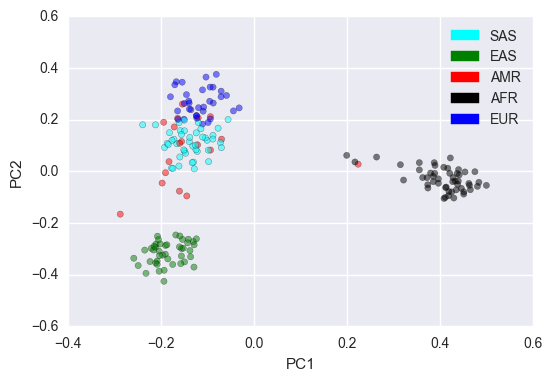

In [42]:
pca_table = vds_pca.samples_keytable().to_pandas()
colors = {'AFR': 'black', 'AMR': 'red', 'EAS': 'green', 'EUR': 'blue', 'SAS': 'cyan'}
plt.scatter(pca_table["sa.pca.PC1"], pca_table["sa.pca.PC2"], c = pca_table["sa.pheno.SuperPopulation"].map(colors), alpha = .5)
plt.xlabel("PC1")
plt.ylabel("PC2")
legend_entries = [mpatches.Patch(color= c, label=pheno) for pheno, c in colors.items()]
plt.legend(handles=legend_entries)
plt.show()

## Association testing

Now that we have a clean dataset with principal component annotations, let's test for association between genetic variation and the phenotypes CaffeineConsumption (continuous) and PurpleHair (dichotomous).

### Linear regression with covariates

Let's run linear regression on `vds_QCed`. First, we will filter to variants with a allele frequency between 5% and 95%. Next, we use the [`linreg`](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.linreg) method, specifying the response variable `y` to be the sample annotation `sa.pheno.CaffeineConsumption`. We use four sample covariates in addition to the (implicit) intercept: `sa.pca.PC1`, `sa.pca.PC2`, `sa.pca.PC3`, `sa.pheno.isFemale`.

In [44]:
vds_gwas = (vds_QCed
    .filter_variants_expr('va.qc.AF > 0.05 && va.qc.AF < 0.95')
    .annotate_samples_table(vds_pca.samples_keytable(), expr='sa.pca = table.pca')
    .linreg('sa.pheno.CaffeineConsumption', 
            covariates=['sa.pca.PC1', 'sa.pca.PC2', 'sa.pca.PC3', 'sa.pheno.isFemale']))

The results of linear regression are stored as variant annotations and can be accessed with the root name `va.linreg`. To check for p-value inflation and significant associations, let's create a log-scaled [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot). We'll be making such plots a few times, so let's first define a function for this purpose.

In [45]:
def qqplot(pvals, xMax, yMax):
    spvals = sorted(filter(lambda x: not(isnan(x)), pvals))
    exp = [-log(float(i) / len(spvals), 10) for i in np.arange(1, len(spvals) + 1, 1)]
    obs = [-log(p, 10) for p in spvals]
    plt.scatter(exp, obs)
    plt.plot(np.arange(0, max(xMax, yMax)), c="red")
    plt.xlabel("Expected p-value (-log10 scale)")
    plt.ylabel("Observed p-value (-log10 scale)")
    plt.xlim(0, xMax)
    plt.ylim(0, yMax)
    plt.show()

With this new function, we can make a Q-Q plot for our linear regression as follows.

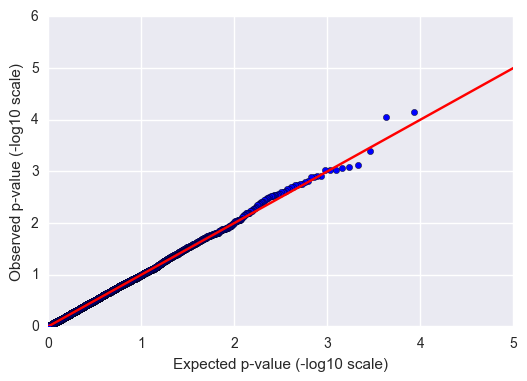

In [46]:
linreg_pvals = sorted(vds_gwas.variants_keytable().to_pandas()["va.linreg.pval"])
qqplot(linreg_pvals, 5, 6)

### Logistic regression with covariates

We continue from `vds_gwas`. The logistic regression method [`logreg`](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.logreg) also takes a test type argument. We will use the Wald test.

In [47]:
vds_gwas = (vds_gwas
    .logreg(test='wald', y='sa.pheno.PurpleHair',
            covariates=['sa.pca.PC1', 'sa.pca.PC2', 'sa.pca.PC3', 'sa.pheno.isFemale']))

We can reuse our Q-Q plot function:

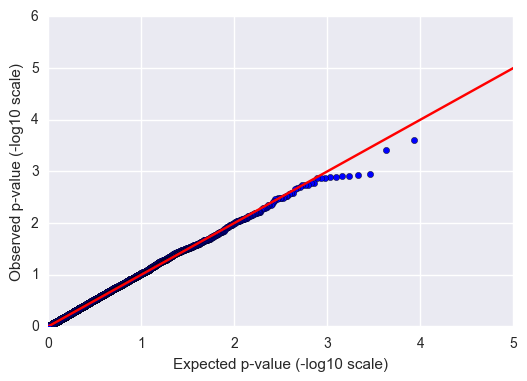

In [48]:
logreg_pvals = vds_gwas.variants_keytable().to_pandas()["va.logreg.pval"]
qqplot(logreg_pvals, 5, 6)

### Fisher's Exact Test for Rare Variants

We'll start with `vds_QCed` here (our `vds_gwas` isn't appropriate for rare variant tests because we filtered them all out!). This time we filter to rare variants (allele frequency less than 5% or greater than 95%). Next we annotate variants with four counts about the aggregate statistics of the samples at each position. These new variant annotations can be used as inputs to [Fisher's Exact Test](https://en.wikipedia.org/wiki/Fisher's_exact_test) test which takes as input four integers representing a 2 x 2 contingency table. We define the variant annotation `va.fet` to be the output of the `fet` function in the [expression language](https://hail.is/expr_lang.html). The results are stored in vds_fet with Q-Q plot below.

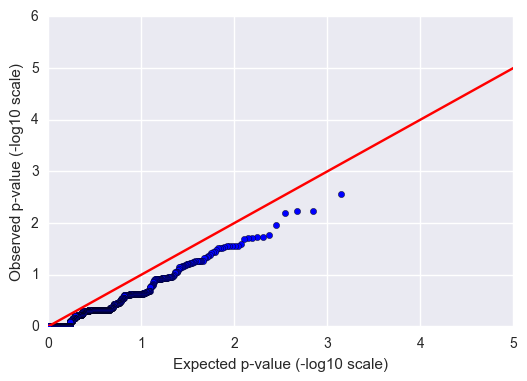

In [49]:
rare_variant_annotations = [
    '''va.minorCase = 
        gs.filter(g => sa.pheno.PurpleHair && g.isHet()).count() +
        2 * gs.filter(g => sa.pheno.PurpleHair && g.isHomVar()).count()''',
    '''va.minorControl = 
        gs.filter(g => !sa.pheno.PurpleHair && g.isHet()).count() + 
        2 * gs.filter(g => !sa.pheno.PurpleHair && g.isHomVar()).count()''',
    '''va.majorCase = 
        gs.filter(g => sa.pheno.PurpleHair && g.isHet()).count() +
        2 * gs.filter(g => sa.pheno.PurpleHair && g.isHomRef()).count()''',
    '''va.majorControl = 
        gs.filter(g => !sa.pheno.PurpleHair && g.isHet()).count() +
        2 * gs.filter(g => !sa.pheno.PurpleHair && g.isHomRef()).count()''' ]

vds_fet = (vds_QCed
    .filter_variants_expr('va.qc.AF <= 0.05 || va.qc.AF >= 0.95')
    .annotate_variants_expr(rare_variant_annotations)
    .annotate_variants_expr('''va.fet = 
                                fet(va.minorCase.toInt(), va.minorControl.toInt(),
                                    va.majorCase.toInt(), va.majorControl.toInt())'''))

fet_pvals = vds_fet.variants_keytable().to_pandas()["va.fet.pValue"]
qqplot(fet_pvals, 5, 6)

## Eplilogue

Congrats! If you've made it this far, you're perfectly primed to read the [Overview](https://hail.is/hail/overview.html), look through the [Hail objects](https://hail.is/hail/types.html) representing many core concepts in genetics, and check out the many Hail functions defined in the [Python API](https://hail.is/hail/api.html). As you use Hail for your own science, we'd love to hear from you on [Gitter chat](https://gitter.im/hail-is/hail) or the [discussion forum](http://discuss.hail.is).

For reference, here's the full workflow to all tutorial endpoints combined into one script, assuming you've already created the expression strings like `filter_condition_ab` above.

In [ ]:
sample_annotations = hc.import_table('1000Genomes.sample_annotations', impute=True).key_by('Sample')

vds_gAB_vCR = (hc.import_vcf('1000Genomes_248samples_coreExome10K.vcf.bgz')
         .split_multi()
         .annotate_samples_table(table, root='sa.pheno')
         .filter_genotypes(filter_condition_ab)
         .filter_variants_expr('gs.fraction(g => g.isCalled()) > 0.95')
         .sample_qc())

vds_QCed = (vds_gAB_vCR
    .annotate_samples_table(vds_gAB_vCR.samples_keytable(), expr = 'sa.qc = table.qc')
    .filter_samples_expr('sa.qc.callRate >= 0.97 && sa.qc.gqMean >= 20')
    .variant_qc()
    .annotate_variants_expr(sex_aware_hwe_exprs)
    .filter_variants_expr(hwe_filter_expression + '&& va.qc.gqMean >= 20')
    .impute_sex(maf_threshold=0.05)
    .annotate_samples_expr('sa.sexcheck = sa.pheno.isFemale == sa.imputesex.isFemale')
    .filter_samples_expr('sa.sexcheck || isMissing(sa.sexcheck)'))

vds_pca = (vds_QCed.filter_variants_table(KeyTable.import_interval_list('purcell5k.interval_list'))
    .pca(scores='sa.pca'))

vds_gwas = (vds_QCed
    .filter_variants_expr('va.qc.AF > 0.05 && va.qc.AF < 0.95')
    .annotate_samples_table(vds_pca.samples_keytable(), expr='sa.pca = table.pca')
    .linreg('sa.pheno.CaffeineConsumption', 
            covariates=['sa.pca.PC1', 'sa.pca.PC2', 'sa.pca.PC3', 'sa.pheno.isFemale'])
    .logreg(test='wald', y='sa.pheno.PurpleHair',
            covariates=['sa.pca.PC1', 'sa.pca.PC2', 'sa.pca.PC3', 'sa.pheno.isFemale']))

vds_fet = (vds_QCed
    .filter_variants_expr('va.qc.AF <= 0.05 || va.qc.AF >= 0.95')
    .annotate_variants_expr(rare_variant_annotations)
    .annotate_variants_expr('''va.fet = fet(va.minorCase.toInt(), va.minorControl.toInt(),
                                            va.majorCase.toInt(), va.majorControl.toInt())'''))